# Introduction

We start as always by loading the packages.

In [23]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')

from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, RobustScaler, Normalizer, StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split

from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM

import math
import scipy.stats as ss

SEED = 42

Next, we load the data.

In [24]:
data = pd.read_csv('../dset/kaggle_river_playground/sample_submission.csv')
print(data.shape)
data.head()

(3500, 37)


,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,9.545,9.265,8.110,8.43,7.15,0.180,...,4.95,1.730,1.800,4.800,3.15,10.665,10.465,16.645,5.75,10.37
1,1,9.10,13.533,40.90,8.770,9.265,6.015,10.07,7.15,1.107,...,20.05,9.530,7.695,4.550,6.95,2.040,5.200,5.725,2.95,2.23
2,2,8.21,3.710,5.42,8.770,9.265,4.550,10.07,7.15,0.020,...,4.58,3.025,3.960,4.935,4.95,4.725,6.075,6.750,3.50,3.17
3,3,8.39,8.700,8.10,9.500,9.200,5.200,8.67,6.67,0.280,...,8.45,2.070,1.730,6.300,4.70,3.500,6.200,8.670,2.90,7.37
4,4,8.07,8.050,8.65,7.960,9.265,3.290,10.07,7.15,0.360,...,2.02,1.730,0.760,4.800,4.97,3.950,2.800,8.400,3.50,3.90


Looking at the [data source](https://www.kaggle.com/datasets/vbmokin/dissolved-oxygen-prediction-in-river-water) from which this synthetic data was generated, we can see that this data measures various features at a series of seven stations over a period of months.  Those features include Dissolved Oxygen, Ammonium ion concentration, Nitrite ion concentration, Nitrate ion concentration, and Biochemical Oxygen Demand.

The science behind this is simple.  The concentration of Ammonium ions, NH4, in water can have an indirect effect on the amount of dissolved oxygen (O2) in aquatic ecosystems due to a process known as [Nitrification](https://www.epa.gov/sites/default/files/2015-09/documents/nitrification_1.pdf).

It is a two-step aerobic process, where bacteria first oxidizes ammonia to nitrite (NH3 + O2 → NO2 + 3H), and then bacteria oxidizes the nitrite into nitrate (NO2 + H2O → NO3 + 2H).

# Establishing a Baseline

Since we have a fixed model, we have to focus on data-centric approaches to get any improvement on our ability to predict dissolved oxygen at Station Zero.  A good approach in data science is to establish a baseline result.  That way you can determine if you're improving or not.

We will use cross-validation on our model in order to determine a baseline.  First, we take the model provided in the competition page.

In [25]:
rf = RandomForestRegressor(
       n_estimators=1000,
       max_depth=7,
       n_jobs=-1,
       random_state=42)

Next, we'll gather our 10-fold cross validation score.

In [26]:
X, y = data.drop('target', axis = 1), data.target

That's our baseline.  We want to start using Data-centric methods to improve this score.

Looking at the [Public Notebooks](https://www.kaggle.com/competitions/playground-series-s3e21/code) for this competition, it looks as if clipping is a popular technique.  Let's try that!

# Target Clipping

We start by clipping the target with the following code.

In [27]:
data.target = data.target.clip(lower = 7, upper = 20)

Now let's detect outliers, using a couple different methods.

In [28]:
svm = SGDOneClassSVM(nu=0.55)
yhat = svm.fit_predict(data.drop('id', axis = 1))

print('Outliers detected (SGD One Class SVM): {}'.format(np.count_nonzero(yhat == -1)))

mask = yhat != -1
data_SVM = data.loc[mask, :].reset_index(drop = True)

X_SVM, Y_SVM = data_SVM.drop('target', axis = 1), data_SVM.target

# scores = cross_val_score(rf, 
#                        X_SVM,
#                        Y_SVM,
#                        cv = 10, 
#                        scoring = 'neg_mean_squared_error',
#                        n_jobs = -1)

# print(f'[{svm.__class__.__name__}] --> MSE Mean: {scores.mean()}, Standard Deviation: {scores.std()}')
data_SVM.head()

Outliers detected (SGD One Class SVM): 28


,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,9.545,9.265,8.110,8.43,7.15,0.180,...,4.95,1.730,1.800,4.800,3.15,10.665,10.465,16.645,5.75,10.37
1,1,9.10,13.533,40.90,8.770,9.265,6.015,10.07,7.15,1.107,...,20.05,9.530,7.695,4.550,6.95,2.040,5.200,5.725,2.95,2.23
2,2,8.21,3.710,5.42,8.770,9.265,4.550,10.07,7.15,0.020,...,4.58,3.025,3.960,4.935,4.95,4.725,6.075,6.750,3.50,3.17
3,3,8.39,8.700,8.10,9.500,9.200,5.200,8.67,6.67,0.280,...,8.45,2.070,1.730,6.300,4.70,3.500,6.200,8.670,2.90,7.37
4,4,8.07,8.050,8.65,7.960,9.265,3.290,10.07,7.15,0.360,...,2.02,1.730,0.760,4.800,4.97,3.950,2.800,8.400,3.50,3.90


In [29]:
iso = IsolationForest(random_state = 0)
yhat = iso.fit_predict(data_SVM.drop('id', axis = 1))

print('Outliers detected (Isolation Forest): {}'.format(np.count_nonzero(yhat == -1)))

mask = yhat != -1
data_ISO = data_SVM.loc[mask, :].reset_index(drop = True)

X_ISO, Y_ISO = data_ISO.drop("target", axis=1), data_ISO.target

#scores = cross_val_score(rf, 
#                        X_ISO,
#                        Y_ISO,
#                        cv = 10, 
#                        scoring = 'neg_mean_squared_error',
#                        n_jobs = -1)
#
#print(f'[{iso.__class__.__name__}] --> MSE Mean: {scores.mean()}, Standard Deviation: {scores.std()}')

Outliers detected (Isolation Forest): 83


In [30]:
lof = LocalOutlierFactor(n_neighbors=3, contamination=0.1)
yhat = lof.fit_predict(data_ISO.drop(['id', 'target'], axis = 1))

print('Outliers detected (Local Outlier Factor): {}'.format(np.count_nonzero(yhat == -1)))

mask = yhat != -1
data_final = data_ISO.loc[mask, :].reset_index(drop = True)

X_LOF, Y_LOF = data_final.drop('target', axis = 1), data_final.target

#scores = cross_val_score(rf, 
#                        X_LOF,
#                        Y_LOF,
#                        cv = 10, 
#                        scoring = 'neg_mean_squared_error',
#                        n_jobs = -1)
#
#print(f'[{lof.__class__.__name__}] --> MSE Mean: {scores.mean()}, Standard Deviation: {scores.std()}')

Outliers detected (Local Outlier Factor): 339


We can plot the target values employing these various methods of outlier detection.

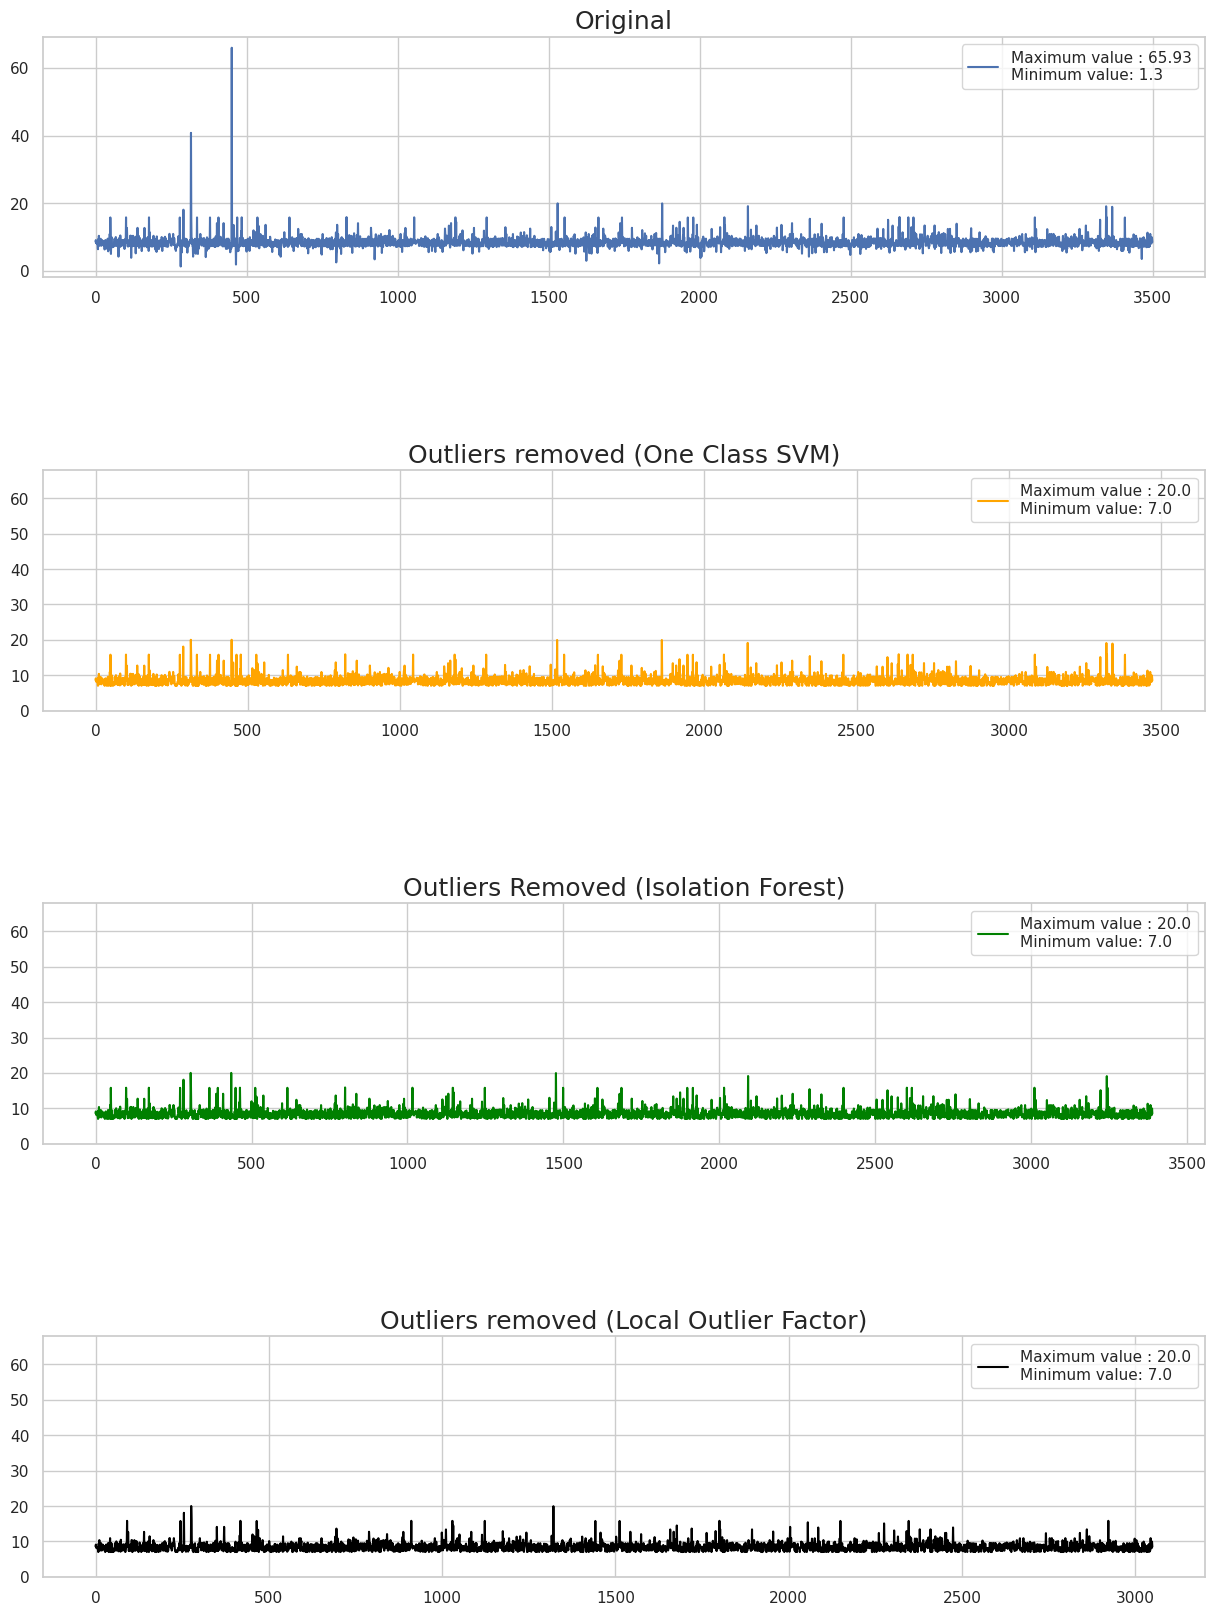

In [31]:
plt.rcParams['figure.figsize'] = (15, 20)

fig, axs = plt.subplots(4)
fig.subplots_adjust(hspace = 0.8)

axs[0].set_title('Original', fontsize = 18)
axs[0].plot(y, label = f'Maximum value : {max(y)}\nMinimum value: {round(min(y), 3)}')
axs[0].legend()

axs[2].set_title('Outliers Removed (Isolation Forest)', fontsize = 18)
axs[2].set_ylim(0, 68)
axs[2].plot(Y_ISO, color = 'green', label = f'Maximum value : {max(Y_ISO)}\nMinimum value: {round(min(Y_ISO), 3)}')
axs[2].legend()

axs[1].set_title('Outliers removed (One Class SVM)', fontsize = 18)
axs[1].set_ylim(0, 68)
axs[1].plot(Y_SVM, color = 'orange', label = f'Maximum value : {max(Y_SVM)}\nMinimum value: {round(min(Y_SVM), 3)}')
axs[1].legend()

axs[3].set_title('Outliers removed (Local Outlier Factor)', fontsize = 18)
axs[3].set_ylim(0, 68)
axs[3].plot(Y_LOF, color = 'black', label = f'Maximum value : {max(Y_LOF)}\nMinimum value: {round(min(Y_LOF), 3)}')
axs[3].legend()

In [32]:
X_final, y_final = data_final.drop('target', axis = 1), data_final.target

# Feature Selection

Let's determine the relative importance of our features.

In [33]:
rf.fit(X_final, y_final)

imp = pd.DataFrame({'importances': rf.feature_importances_}, index = X_final.columns).sort_values(by = 'importances', ascending = False)

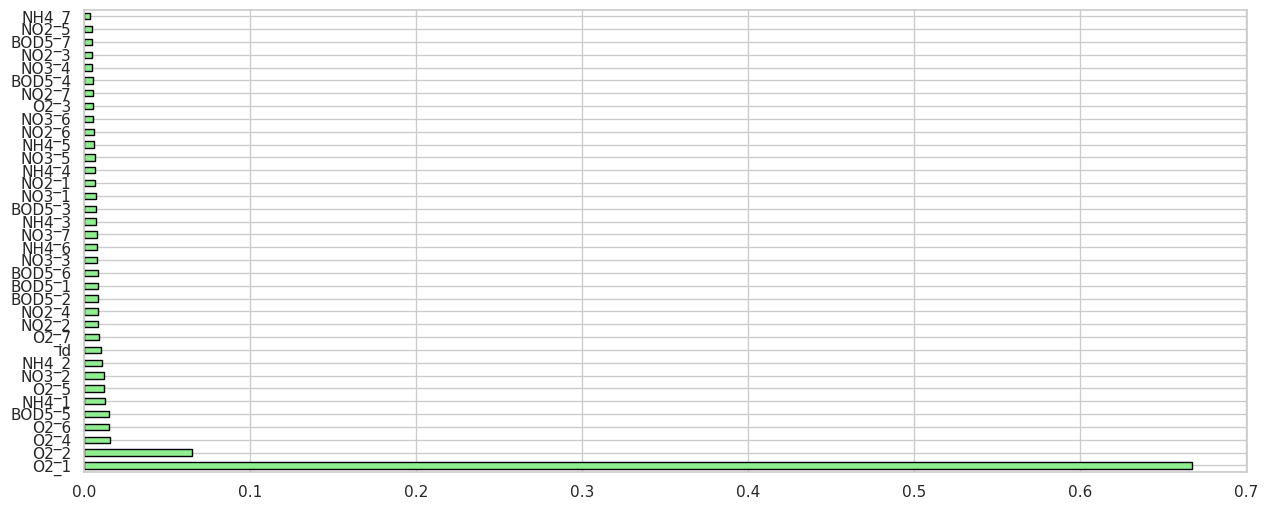

In [34]:
imp.plot(figsize = (15, 6), kind = 'barh', color = 'lightgreen', edgecolor = 'black')\
.get_legend().remove()

We will select the 5 most important features, excluding Dissolved Oxygen values beyond station 2.

In [35]:
selected_features = [
    'O2_1', 
    'O2_2',
    'BOD5_5',
    'NH4_1'
]

scores = cross_val_score(rf, 
                        X_final[selected_features],
                        y_final,
                        cv = 10, 
                        scoring = 'neg_mean_squared_error',
                        n_jobs = -1)

print(f'[ENSEMBLE + FS + CLIPPING_7_20] --> MSE Mean: {scores.mean()}, Standard Deviation: {scores.std()}')

[ENSEMBLE + FS + CLIPPING_7_20] --> MSE Mean: -0.8554649678328383, Standard Deviation: 0.13759419178892923


In [36]:
data_final.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,9.545,9.265,8.110,8.43,7.15,0.180,...,4.95,1.730,1.800,4.800,3.15,10.665,10.465,16.645,5.75,10.37
1,1,9.10,13.533,40.90,8.770,9.265,6.015,10.07,7.15,1.107,...,20.05,9.530,7.695,4.550,6.95,2.040,5.200,5.725,2.95,2.23
2,2,8.21,3.710,5.42,8.770,9.265,4.550,10.07,7.15,0.020,...,4.58,3.025,3.960,4.935,4.95,4.725,6.075,6.750,3.50,3.17
3,3,8.39,8.700,8.10,9.500,9.200,5.200,8.67,6.67,0.280,...,8.45,2.070,1.730,6.300,4.70,3.500,6.200,8.670,2.90,7.37
4,4,8.07,8.050,8.65,7.960,9.265,3.290,10.07,7.15,0.360,...,2.02,1.730,0.760,4.800,4.97,3.950,2.800,8.400,3.50,3.90


Here's where we rely on the collaborative nature of the Kaggle community to employ a couple [tricks](https://www.kaggle.com/competitions/playground-series-s3e21/discussion/434519).

In [37]:
bad_labels = [2365, 1089, 1936, 1680, 211,2294,448, 437,309,1684]
data_final = data_final[~data_final['id'].isin(bad_labels)]

Now we can drop all but our selected features by setting everything else to 0.  This way, the fixed model will only focus on the important features without compromising the format of our final submission.

In [38]:
for column in X.columns:
    if column not in selected_features:
        data_final[column] = 0

We can look back to Kaggle for [one last trick](https://www.kaggle.com/code/franciscofeng/drop-rows-with-low-clipped-target-value).  It was discovered that we can get an improvement by randomly choosing 150 rows with the min boundary, and removing them from the dataset.  The competition submission requires that no rows be added, but rows can be removed at will (or in this case, at random).

In [39]:
drop_index = np.random.choice(data_final[data_final['target']==7].index.to_numpy(), 150, replace=False)

data_final.drop(drop_index, inplace = True)

Now, in order to try something different, we are going to inject some noise into our features.  It might not help, but I'm throwing everything and the kitchen sink at this dataset.

In [40]:
#sigma = 0.05
#noise = np.random.normal(0, sigma, data_final.shape)

In [41]:
#for i, column in enumerate(selected_features):
#    data_final[column] = data_final[column] + noise[:, i]

# Submission

We are now ready to prepare our submission.

In [42]:
submission = data_final.reset_index(drop = True).copy()

submission.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,0,0,0,0,0,0.180,...,0,0,0,0,0,0,0,16.645,0,0
1,0,9.10,13.533,40.90,0,0,0,0,0,1.107,...,0,0,0,0,0,0,0,5.725,0,0
2,0,8.21,3.710,5.42,0,0,0,0,0,0.020,...,0,0,0,0,0,0,0,6.750,0,0
3,0,8.39,8.700,8.10,0,0,0,0,0,0.280,...,0,0,0,0,0,0,0,8.670,0,0
4,0,8.07,8.050,8.65,0,0,0,0,0,0.360,...,0,0,0,0,0,0,0,8.400,0,0


In [43]:
submission.to_csv('submission.csv', index = False)

# Final Comments

Much of this relies on randomness, so there's no telling how it will perform on the private leader board.  We'll have to wait and see.  

A big thank you to Adel-in-Mil for providing the code.  I think I made only one alteration (choosing more features).  I just wanted a notebook where I could explain these steps (and a smidge of science).

Hope you enjoyed this tutorial!